## X-Forum, Projet de MAP

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# First strategy

In [186]:
#take one random goodie from 2 boxes (first strategy)
def choose_a_goodie_first_st(L): #L - list of two elements
    i = random.randint(0, 1)
    if i == 0:
        return [L[0]-1, L[1]]
    else:
        return [L[0], L[1]-1]

Simulation of the first variable.
We choose N, simulate A_N k times.

In [168]:
N = 1000 #number of goodies
sqrtN = math.sqrt(N)
k = 10000 #number of simulations
G_N = np.zeros(k) #number of goodies left

for i in range(k): #i - index of the simulation
    boxes = [N, N]
    #taking goodies while there are in both boxes
    while ((boxes[0] > 0) & (boxes[1] > 0)):
        boxes = choose_a_goodie_first_st(boxes)
    G_N[i] = (boxes[0] + boxes[1])

In [231]:
print G_N[0:10]

[ 54.  21.  22.  12.  41.  10.  42.  99.   2.   3.]


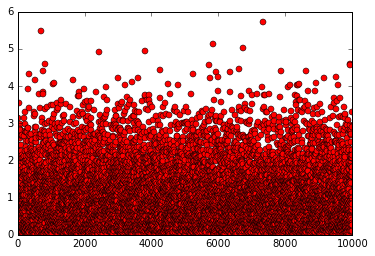

In [232]:
plt.plot(np.arange(k), G_N/sqrtN, 'ro')

In [233]:
from collections import Counter
c = Counter(G_N)
max_number_of_goodies_left = int(max(c.keys()))
all_possible_numbers_of_goodies_left = np.arange(1, max_number_of_goodies_left + 1)
res = np.zeros(max_number_of_goodies_left + 1)

for i in all_possible_numbers_of_goodies_left:
    res[i] = c[i]
probability = (1.0/k)*np.array(res[1:max_number_of_goodies_left + 1])

In [234]:
A_N_possibles = 1.0*all_possible_numbers_of_goodies_left/sqrtN
width = 10.0/len(A_N_possibles) #have to check

<Container object of 181 artists>

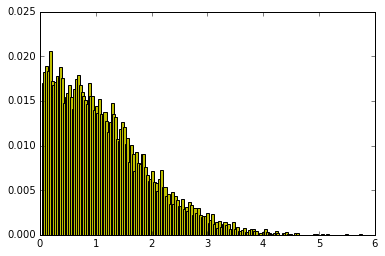

In [245]:
plt.bar(A_N_possibles, probability, width=width, color='y')

In [236]:
A_N_possibles[0]

0.031622776601683791

<Container object of 181 artists>

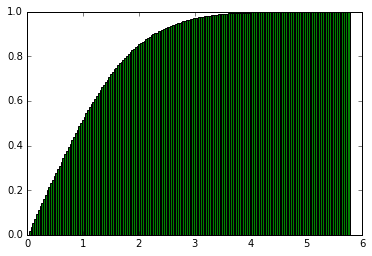

In [228]:
from numpy import cumsum
CDF = cumsum(probability) #cumulative distribution function
plt.bar(A_N_possibles, CDF, width=width, color='g')

In [219]:
print CDF[0], norm.cdf(A_N_possibles[0], 0, 1.0/sqrt2)

0.017 0.517835295865


<Container object of 181 artists>

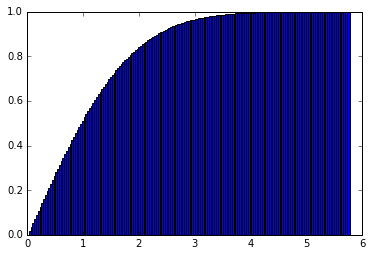

In [244]:
from scipy.stats import norm
sqrt2 = math.sqrt(2)
plt.bar(A_N_possibles, 2*norm.cdf(A_N_possibles, 0, sqrt2)-1, width=width, color='b')

# Second strategy

In [9]:
#take one random goodie from 1 box (second strategy)
def choose_a_goodie_second_st(L): #L - list of two elements, first 
    p = 1.0*L[0]/(L[0]+L[1]) # probability of taking read goodie
    i = np.random.binomial(1, p) #i = 1 with proba p et i = 0 with proba 1-p
    if i == 0:
        return [L[0], L[1]-1]
    else:
        return [L[0]-1, L[1]]

Simulation of the second variable.
We choose N, simulate H_N k times and compare with variable g of geometric distribition.

In [174]:
N = 1000 #number of goodies
k = 10000 #number of simulations
H_N = np.zeros(k) #number of goodies left

for i in range(k): #i - index of the simulation
    boxes = [N, N]
    #taking goodies while there are in both boxes
    while ((boxes[0] > 0) & (boxes[1] > 0)):
        boxes = choose_a_goodie_second_st(boxes)
    H_N[i] = boxes[0] + boxes[1]

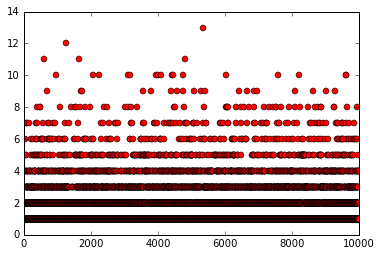

In [175]:
plt.plot(np.arange(k), H_N, 'ro')

In [176]:
from collections import Counter
c = Counter(H_N)
max_number_of_goodies_left = int(max(c.keys()))
all_possible_numbers_of_goodies_left = range(1, 1 + max_number_of_goodies_left)
res = np.zeros(max_number_of_goodies_left + 1)

for i in all_possible_numbers_of_goodies_left:
    res[i] = c[i]
probability = (1.0/k)*np.array(res[1:max_number_of_goodies_left + 1])

<Container object of 13 artists>

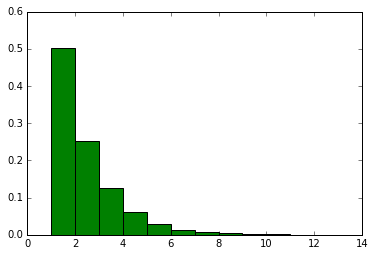

In [177]:
plt.bar(all_possible_numbers_of_goodies_left, probability, width=1.0, color='j')